In [2]:
import tsflex
print(tsflex.__version__)

0.2.3


## Get the data

In [3]:
from tsflex.utils.data import load_empatica_data

df_tmp, df_acc, df_gsr, df_ibi = load_empatica_data(["tmp", "acc", "gsr", "ibi"])

In [4]:
from pandas.tseries.frequencies import to_offset

data = [df_tmp, df_acc, df_gsr, df_ibi]
for df in data:
    print("Time-series:", df.columns.values)
    print(df.shape)
    try:
        print("Sampling rate:", 1 / pd.to_timedelta(to_offset(pd.infer_freq(df.index))).total_seconds(), "Hz")
    except:
        print("Irregular sampling rate")
    print()

Time-series: ['TMP']
(30200, 1)
Irregular sampling rate

Time-series: ['ACC_x' 'ACC_y' 'ACC_z']
(241620, 3)
Irregular sampling rate

Time-series: ['EDA']
(30204, 1)
Irregular sampling rate

Time-series: ['IBI']
(1230, 1)
Irregular sampling rate



## Look at the data

In [5]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=len(data), cols=1, shared_xaxes=True, 
    subplot_titles=[df.columns.values[0].split('_')[0] for df in data],
    vertical_spacing=0.1,
)

for plot_idx, df in enumerate(data, 1):
    # Select first minute of data
    sub_df = df.first('1min')
    for col in df.columns:
        fig.add_trace(
            go.Scattergl(x=sub_df.index, y=sub_df[col].values, name=col, mode='markers'),
            row=plot_idx, col=1
        )

fig.update_layout(height=len(data)*200)

fig.show(renderer='iframe')

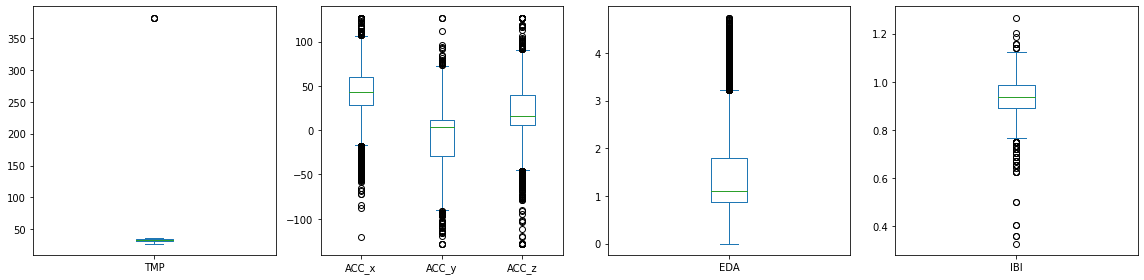

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,4))

for plot_idx, df in enumerate(data):
    df.plot(kind='box', ax=axes[plot_idx])
plt.tight_layout()

These visualizations indicate that some preprocessing might be necessary for the signals (some sort of clipping)

# tsflex processing

This is roughly identical to the processing of notebook containing the example code of the paper.

In [7]:
import pandas as pd; import numpy as np; from scipy.signal import savgol_filter
from tsflex.processing import SeriesProcessor, SeriesPipeline

# Create the processing functions
def clip_data(sig: pd.Series, min_val=None, max_val=None) -> np.ndarray:
    return np.clip(sig,  a_min=min_val, a_max=max_val)

def smv(*sigs) -> pd.Series:
    sig_prefixes = set(sig.name.split('_')[0] for sig in sigs)
    result = np.sqrt(np.sum([np.square(sig) for sig in sigs], axis=0))
    return pd.Series(result, index=sigs[0].index, name='|'.join(sig_prefixes)+'_'+'SMV')

# Create the series processors (with their keyword arguments)
tmp_clippper = SeriesProcessor(clip_data, series_names="TMP", max_val=35)
acc_savgol = SeriesProcessor(
    savgol_filter, ["ACC_x", "ACC_y", "ACC_z"], window_length=33, polyorder=2
)
acc_smv = SeriesProcessor(smv, ("ACC_x", "ACC_y", "ACC_z"))

# Create the series pipeline & process the data
series_pipe = SeriesPipeline([tmp_clippper, acc_savgol, acc_smv])
series_pipe

[
	clip_data {'max_val': 35} :  ('TMP',)
	savgol_filter {'window_length': 33, 'polyorder': 2} :  ('ACC_x',) ('ACC_y',) ('ACC_z',)
	smv {} :  ('ACC_x', 'ACC_y', 'ACC_z')
]

In [8]:
out_data = series_pipe.process(data, drop_keys=["ACC_x", "ACC_y", "ACC_z"])

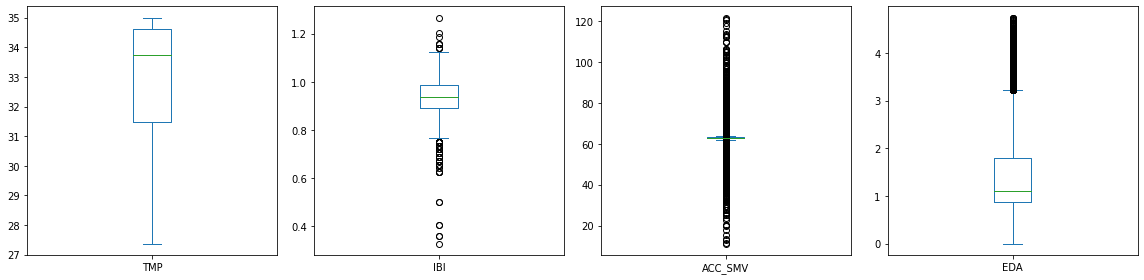

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,4))

for plot_idx, df in enumerate(out_data):
    df.plot(kind='box', ax=axes[plot_idx])
plt.tight_layout()

# tsflex feature extraction with [tsfresh](https://github.com/blue-yonder/tsfresh) integration

In [10]:
# !pip install tsfresh

> Useful links;  
> [List of all tsfresh features](https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html)  
> [More detailed documentation of the tsfresh features](https://tsfresh.readthedocs.io/en/latest/api/tsfresh.feature_extraction.html#module-tsfresh.feature_extraction.feature_calculators)  
> [More detailed documentation of the tsfresh feature extraction settings](https://tsfresh.readthedocs.io/en/latest/text/feature_extraction_settings.html)

[tsfresh feature extraction settings](https://github.com/blue-yonder/tsfresh/blob/main/tsfresh/feature_extraction/settings.py) is how tsfresh represents a collection of features (with their parameters).  
**=> requires wrapping this settings object in a `tsfresh_settings_wrapper` for interoperability with tsflex**.

[tsfresh feature-funtions](https://github.com/blue-yonder/tsfresh/blob/main/tsfresh/feature_extraction/feature_calculators.py) are either of type `simple` or `combiner`.
* `simple`: feature calculators which calculate a single number  
  **=> integrates natively with tsflex**
* `combiner`: feature calculates which calculate a bunch of features for a list of parameters. These features are returned as a list of (key, value) pairs for each input parameter.  
  **=> requires wrapping the function to only extract the values of the returned tuples**  
  
Of course, feature functions that require other keyword arguments, should be wrapped in a `FuncWrapper`

In [11]:
# This wrapper handles tsfresh its feature extraction settings
from tsflex.features.integrations import tsfresh_settings_wrapper
# This wrappers handles tsfresh its combiner functions
from tsflex.features.integrations import tsfresh_combiner_wrapper

In [12]:
from tsflex.features import FeatureCollection, MultipleFeatureDescriptors

## Using tsfresh feature extraction settings

In [13]:
# Import some preset feature extraction setting from tsfresh
from tsfresh.feature_extraction import MinimalFCParameters, EfficientFCParameters

Calculate the features for a tsfresh feature extraction setting.  
Note that;
* `tsfresh_settings_wrapper` transforms this feature extraction settings object to a list of features that you can directly pass as the `function` argument of tsflex `MultipleFeatureDescriptors`.

In [14]:
simple_feats = MultipleFeatureDescriptors(
    functions=tsfresh_settings_wrapper(MinimalFCParameters()),
    series_names=["ACC_SMV", "EDA", "TMP"],
    windows=["5min", "2.5min"],
    strides=["2.5min"],
)
feature_collection = FeatureCollection(simple_feats)
feature_collection

ACC_SMV: (
	win: 5m    , stride: 2m30s: [
		FeatureDescriptor - func: FuncWrapper(sum_values, ['sum_values'], {}),
		FeatureDescriptor - func: FuncWrapper(median, ['median'], {}),
		FeatureDescriptor - func: FuncWrapper(mean, ['mean'], {}),
		FeatureDescriptor - func: FuncWrapper(length, ['length'], {}),
		FeatureDescriptor - func: FuncWrapper(standard_deviation, ['standard_deviation'], {}),
		FeatureDescriptor - func: FuncWrapper(variance, ['variance'], {}),
		FeatureDescriptor - func: FuncWrapper(root_mean_square, ['root_mean_square'], {}),
		FeatureDescriptor - func: FuncWrapper(maximum, ['maximum'], {}),
		FeatureDescriptor - func: FuncWrapper(minimum, ['minimum'], {}),
	]
	win: 2m30s , stride: 2m30s: [
		FeatureDescriptor - func: FuncWrapper(sum_values, ['sum_values'], {}),
		FeatureDescriptor - func: FuncWrapper(median, ['median'], {}),
		FeatureDescriptor - func: FuncWrapper(mean, ['mean'], {}),
		FeatureDescriptor - func: FuncWrapper(length, ['length'], {}),
		FeatureDescriptor

In [15]:
features_df = feature_collection.calculate(out_data, return_df=True, show_progress=True)
features_df

  0%|          | 0/54 [00:00<?, ?it/s]

,ACC_SMV__length__w=2m30s_s=2m30s,ACC_SMV__length__w=5m_s=2m30s,ACC_SMV__maximum__w=2m30s_s=2m30s,ACC_SMV__maximum__w=5m_s=2m30s,ACC_SMV__mean__w=2m30s_s=2m30s,ACC_SMV__mean__w=5m_s=2m30s,ACC_SMV__median__w=2m30s_s=2m30s,ACC_SMV__median__w=5m_s=2m30s,ACC_SMV__minimum__w=2m30s_s=2m30s,ACC_SMV__minimum__w=5m_s=2m30s,...,TMP__minimum__w=2m30s_s=2m30s,TMP__minimum__w=5m_s=2m30s,TMP__root_mean_square__w=2m30s_s=2m30s,TMP__root_mean_square__w=5m_s=2m30s,TMP__standard_deviation__w=2m30s_s=2m30s,TMP__standard_deviation__w=5m_s=2m30s,TMP__sum_values__w=2m30s_s=2m30s,TMP__sum_values__w=5m_s=2m30s,TMP__variance__w=2m30s_s=2m30s,TMP__variance__w=5m_s=2m30s
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-06-13 14:24:43+02:00,4800,NaN,83.457743,NaN,62.975757,NaN,63.199194,NaN,35.954740,NaN,...,27.370001,NaN,27.839542,NaN,0.705593,NaN,16698.359375,NaN,4.978616e-01,NaN
2017-06-13 14:27:13+02:00,4800,9600.0,92.325941,92.325941,63.243716,63.109737,62.936040,63.092027,44.753951,35.954740,...,28.590000,27.370001,29.254473,28.555773,0.300137,0.894276,17551.761719,34250.121094,9.008209e-02,7.997299e-01
2017-06-13 14:29:43+02:00,4800,9600.0,76.211915,92.325941,62.919779,63.081748,62.937682,62.937181,48.631443,44.753951,...,29.850000,28.590000,30.236929,29.749758,0.125977,0.543055,18142.000000,35693.761719,1.587024e-02,2.949089e-01
2017-06-13 14:32:13+02:00,4800,9600.0,81.441751,81.441751,62.730198,62.824989,62.721052,62.854726,41.660656,41.660656,...,30.410000,29.850000,30.854300,30.547174,0.330085,0.396530,18511.519531,36653.519531,1.089563e-01,1.572362e-01
2017-06-13 14:34:43+02:00,4800,9600.0,75.855448,81.441751,62.638828,62.684513,62.582349,62.635014,47.121330,41.660656,...,31.629999,30.410000,32.328682,31.600092,0.366860,0.815469,19395.960938,37907.480469,1.345865e-01,6.649895e-01
2017-06-13 14:37:13+02:00,4800,9600.0,121.564172,121.564172,63.067031,62.852929,62.842908,62.717138,11.223471,11.223471,...,32.549999,31.629999,32.827316,32.578957,0.087902,0.365796,19696.320312,39092.281250,7.726815e-03,1.338068e-01
2017-06-13 14:39:43+02:00,4800,9600.0,83.171716,121.564172,62.789469,62.928250,62.701562,62.804672,43.888400,11.223471,...,32.290001,32.290001,32.640171,32.733879,0.224348,0.194542,19583.640625,39279.960938,5.033220e-02,3.784672e-02
2017-06-13 14:42:13+02:00,4800,9600.0,73.057818,83.171716,62.490946,62.640208,62.441973,62.503425,45.415474,43.888400,...,32.790001,32.290001,33.107750,32.874790,0.275753,0.343154,19863.958984,39447.601562,7.603972e-02,1.177549e-01
2017-06-13 14:44:43+02:00,4800,9600.0,74.364764,74.364764,63.093386,62.792166,63.073617,62.692099,48.989959,45.415474,...,33.630001,32.790001,33.814301,33.462891,0.142286,0.416229,20288.400391,40152.359375,2.024529e-02,1.732462e-01


Extract a lot more tsfresh features (& customize the settings, i.e., remove the slower functions)

In [16]:
slow_funcs = [
"matrix_profile",
"number_cwt_peaks",
"augmented_dickey_fuller",
"partial_autocorrelation",
"agg_linear_trend",
"lempel_ziv_complexity",
"benford_correlation",
"ar_coefficient",
"permutation_entropy",
"friedrich_coefficients",
]

settings = EfficientFCParameters()
for f in slow_funcs:
    del settings[f]

In [17]:
efficient_feats = MultipleFeatureDescriptors(
    functions=tsfresh_settings_wrapper(settings),
    series_names=["ACC_SMV", "EDA", "TMP"],
    windows=["5min", "2.5min"],
    strides=["2.5min"],
)
feature_collection = FeatureCollection(efficient_feats)
feature_collection

ACC_SMV: (
	win: 5m    , stride: 2m30s: [
		FeatureDescriptor - func: FuncWrapper(variance_larger_than_standard_deviation, ['variance_larger_than_standard_deviation'], {}),
		FeatureDescriptor - func: FuncWrapper(has_duplicate_max, ['has_duplicate_max'], {}),
		FeatureDescriptor - func: FuncWrapper(has_duplicate_min, ['has_duplicate_min'], {}),
		FeatureDescriptor - func: FuncWrapper(has_duplicate, ['has_duplicate'], {}),
		FeatureDescriptor - func: FuncWrapper(sum_values, ['sum_values'], {}),
		FeatureDescriptor - func: FuncWrapper(abs_energy, ['abs_energy'], {}),
		FeatureDescriptor - func: FuncWrapper(mean_abs_change, ['mean_abs_change'], {}),
		FeatureDescriptor - func: FuncWrapper(mean_change, ['mean_change'], {}),
		FeatureDescriptor - func: FuncWrapper(mean_second_derivative_central, ['mean_second_derivative_central'], {}),
		FeatureDescriptor - func: FuncWrapper(median, ['median'], {}),
		FeatureDescriptor - func: FuncWrapper(mean, ['mean'], {}),
		FeatureDescriptor - func: Fun

In [18]:
features_df = feature_collection.calculate(out_data, return_df=True, show_progress=True)
features_df

  0%|          | 0/1098 [00:00<?, ?it/s]

/users/jonvdrdo/.venvs/venv37/lib/python3.7/site-packages/tsfresh/feature_extraction/feature_calculators.py:404: FutureWarning:

the 'unbiased'' keyword is deprecated, use 'adjusted' instead

/users/jonvdrdo/.venvs/venv37/lib/python3.7/site-packages/tsfresh/feature_extraction/feature_calculators.py:404: FutureWarning:

the 'unbiased'' keyword is deprecated, use 'adjusted' instead

/users/jonvdrdo/.venvs/venv37/lib/python3.7/site-packages/tsfresh/feature_extraction/feature_calculators.py:404: FutureWarning:

the 'unbiased'' keyword is deprecated, use 'adjusted' instead

/users/jonvdrdo/.venvs/venv37/lib/python3.7/site-packages/tsfresh/feature_extraction/feature_calculators.py:2022: RankWarning:

Polyfit may be poorly conditioned

/users/jonvdrdo/.venvs/venv37/lib/python3.7/site-packages/tsfresh/feature_extraction/feature_calculators.py:404: FutureWarning:

the 'unbiased'' keyword is deprecated, use 'adjusted' instead

/users/jonvdrdo/.venvs/venv37/lib/python3.7/site-packages/tsfresh/fea

,ACC_SMV__abs_energy__w=2m30s_s=2m30s,ACC_SMV__abs_energy__w=5m_s=2m30s,ACC_SMV__absolute_sum_of_changes__w=2m30s_s=2m30s,ACC_SMV__absolute_sum_of_changes__w=5m_s=2m30s,"ACC_SMV__agg_autocorrelation_{'f_agg': 'mean', 'maxlag': 40}__w=2m30s_s=2m30s","ACC_SMV__agg_autocorrelation_{'f_agg': 'mean', 'maxlag': 40}__w=5m_s=2m30s","ACC_SMV__agg_autocorrelation_{'f_agg': 'median', 'maxlag': 40}__w=2m30s_s=2m30s","ACC_SMV__agg_autocorrelation_{'f_agg': 'median', 'maxlag': 40}__w=5m_s=2m30s","ACC_SMV__agg_autocorrelation_{'f_agg': 'var', 'maxlag': 40}__w=2m30s_s=2m30s","ACC_SMV__agg_autocorrelation_{'f_agg': 'var', 'maxlag': 40}__w=5m_s=2m30s",...,TMP__value_count_{'value': 0}__w=2m30s_s=2m30s,TMP__value_count_{'value': 0}__w=5m_s=2m30s,TMP__value_count_{'value': 1}__w=2m30s_s=2m30s,TMP__value_count_{'value': 1}__w=5m_s=2m30s,TMP__variance__w=2m30s_s=2m30s,TMP__variance__w=5m_s=2m30s,TMP__variance_larger_than_standard_deviation__w=2m30s_s=2m30s,TMP__variance_larger_than_standard_deviation__w=5m_s=2m30s,TMP__variation_coefficient__w=2m30s_s=2m30s,TMP__variation_coefficient__w=5m_s=2m30s
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-06-13 14:24:43+02:00,1.908184e+07,NaN,845.268541,NaN,0.007816,NaN,-0.018080,NaN,0.156329,NaN,...,0,NaN,0,NaN,4.978616e-01,NaN,False,NaN,0.025353,NaN
2017-06-13 14:27:13+02:00,1.925024e+07,3.833208e+07,1594.725012,2440.009509,0.124729,0.071714,0.009876,0.004135,0.093267,0.117179,...,0,0.0,0,0.0,9.008209e-02,7.997299e-01,False,False,0.010260,0.031332
2017-06-13 14:29:43+02:00,1.900983e+07,3.826007e+07,490.706943,2085.740695,-0.001736,0.113262,-0.027089,0.017091,0.139843,0.096013,...,0,0.0,0,0.0,1.587024e-02,2.949089e-01,False,False,0.004166,0.018257
2017-06-13 14:32:13+02:00,1.890783e+07,3.791766e+07,455.715321,946.463383,0.000221,0.003012,-0.009138,-0.012666,0.160068,0.152622,...,0,0.0,0,0.0,1.089563e-01,1.572362e-01,False,False,0.010699,0.012982
2017-06-13 14:34:43+02:00,1.884167e+07,3.774950e+07,416.221678,871.977938,0.005686,0.002819,-0.003187,-0.002119,0.153497,0.157399,...,0,0.0,0,0.0,1.345865e-01,6.649895e-01,False,False,0.011349,0.025815
2017-06-13 14:37:13+02:00,1.929179e+07,3.813345e+07,1921.665392,2337.929279,-0.000702,0.001868,-0.000905,0.001162,0.189994,0.187092,...,0,0.0,0,0.0,7.726815e-03,1.338068e-01,False,False,0.002678,0.011229
2017-06-13 14:39:43+02:00,1.896016e+07,3.825194e+07,1178.960583,3101.038975,-0.001382,0.000707,-0.034712,-0.002921,0.128844,0.177474,...,0,0.0,0,0.0,5.033220e-02,3.784672e-02,False,False,0.006874,0.005943
2017-06-13 14:42:13+02:00,1.874805e+07,3.770820e+07,192.714896,1371.676077,0.019942,0.006130,0.041747,-0.010674,0.177429,0.130051,...,0,0.0,0,0.0,7.603972e-02,1.177549e-01,False,False,0.008329,0.010439
2017-06-13 14:44:43+02:00,1.911835e+07,3.786640e+07,583.807838,776.524148,0.051851,0.099877,-0.084894,0.020365,0.116301,0.109125,...,0,0.0,0,0.0,2.024529e-02,1.732462e-01,False,False,0.004208,0.012439


### Plot the EDA features

In [19]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2, cols=1, shared_xaxes=True, 
    subplot_titles=['Raw EDA data', 'EDA features'],
    vertical_spacing=0.1
)

fig.add_trace(
    go.Scattergl(x=df_gsr.index[::4*5], y=df_gsr['EDA'].values[::4*5], name='EDA', mode='markers'),
    row=1, col=1
)

ibi_feats = [c for c in features_df.columns if 'EDA_' in c and 'w=2m30s_' in c]

for col in ibi_feats:
    sub_df = features_df[[col]].dropna()
    if not np.issubdtype(sub_df.values.dtype, np.number):
        continue
    fig.add_trace(
        go.Scattergl(x=sub_df.index, y=sub_df[col].values, name=col, mode='markers'),
        row=2, col=1
    )

fig.update_layout(height=2*350)

fig.show(renderer='iframe')

## Using simple tsfresh features

Integrates natively :)

In [20]:
# Import some simple funtions
from tsfresh.feature_extraction.feature_calculators import (
    abs_energy,
    absolute_sum_of_changes,
    cid_ce,
    variance_larger_than_standard_deviation,
)

from tsflex.features import FeatureCollection, FuncWrapper, MultipleFeatureDescriptors

simple_feats = MultipleFeatureDescriptors(
    functions=[
        abs_energy,
        absolute_sum_of_changes,
        variance_larger_than_standard_deviation,
        FuncWrapper(cid_ce, normalize=True),
    ],
    series_names=["ACC_SMV", "EDA", "TMP"],
    windows=["5min", "2.5min"],
    strides="2min",
)
feature_collection = FeatureCollection(simple_feats)
feature_collection

ACC_SMV: (
	win: 5m    , stride: 2m: [
		FeatureDescriptor - func: FuncWrapper(abs_energy, ['abs_energy'], {}),
		FeatureDescriptor - func: FuncWrapper(absolute_sum_of_changes, ['absolute_sum_of_changes'], {}),
		FeatureDescriptor - func: FuncWrapper(variance_larger_than_standard_deviation, ['variance_larger_than_standard_deviation'], {}),
		FeatureDescriptor - func: FuncWrapper(cid_ce, ['cid_ce'], {'normalize': True}),
	]
	win: 2m30s , stride: 2m: [
		FeatureDescriptor - func: FuncWrapper(abs_energy, ['abs_energy'], {}),
		FeatureDescriptor - func: FuncWrapper(absolute_sum_of_changes, ['absolute_sum_of_changes'], {}),
		FeatureDescriptor - func: FuncWrapper(variance_larger_than_standard_deviation, ['variance_larger_than_standard_deviation'], {}),
		FeatureDescriptor - func: FuncWrapper(cid_ce, ['cid_ce'], {'normalize': True}),
	]
)
EDA: (
	win: 5m    , stride: 2m: [
		FeatureDescriptor - func: FuncWrapper(abs_energy, ['abs_energy'], {}),
		FeatureDescriptor - func: FuncWrapper(absolut

In [21]:
features_df = feature_collection.calculate(out_data, return_df=True)
features_df

,ACC_SMV__abs_energy__w=2m30s_s=2m,ACC_SMV__abs_energy__w=5m_s=2m,ACC_SMV__absolute_sum_of_changes__w=2m30s_s=2m,ACC_SMV__absolute_sum_of_changes__w=5m_s=2m,ACC_SMV__cid_ce__w=2m30s_s=2m,ACC_SMV__cid_ce__w=5m_s=2m,ACC_SMV__variance_larger_than_standard_deviation__w=2m30s_s=2m,ACC_SMV__variance_larger_than_standard_deviation__w=5m_s=2m,EDA__abs_energy__w=2m30s_s=2m,EDA__abs_energy__w=5m_s=2m,...,EDA__variance_larger_than_standard_deviation__w=2m30s_s=2m,EDA__variance_larger_than_standard_deviation__w=5m_s=2m,TMP__abs_energy__w=2m30s_s=2m,TMP__abs_energy__w=5m_s=2m,TMP__absolute_sum_of_changes__w=2m30s_s=2m,TMP__absolute_sum_of_changes__w=5m_s=2m,TMP__cid_ce__w=2m30s_s=2m,TMP__cid_ce__w=5m_s=2m,TMP__variance_larger_than_standard_deviation__w=2m30s_s=2m,TMP__variance_larger_than_standard_deviation__w=5m_s=2m
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-06-13 14:24:43+02:00,1.908184e+07,NaN,845.268541,NaN,13.174428,NaN,True,NaN,184.292831,NaN,...,False,NaN,465024.09375,NaN,9.709995,NaN,10.479591,NaN,False,NaN
2017-06-13 14:26:43+02:00,1.919667e+07,NaN,1574.566142,NaN,14.355881,NaN,True,NaN,289.437164,NaN,...,False,NaN,504830.37500,NaN,2.139997,NaN,0.638482,NaN,False,NaN
2017-06-13 14:27:13+02:00,NaN,3.833208e+07,NaN,2440.009509,NaN,19.582844,NaN,True,NaN,522.263611,...,NaN,False,NaN,978518.625,NaN,11.869993,NaN,8.273287,NaN,False
2017-06-13 14:28:43+02:00,1.900028e+07,NaN,481.406374,NaN,14.614260,NaN,True,NaN,455.612671,NaN,...,False,NaN,538692.06250,NaN,2.180008,NaN,0.710819,NaN,False,NaN
2017-06-13 14:29:13+02:00,NaN,3.821475e+07,NaN,2126.336744,NaN,20.645812,NaN,True,NaN,724.750061,...,NaN,False,NaN,1048903.250,NaN,4.400007,NaN,0.546809,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-06-13 16:23:13+02:00,NaN,3.815810e+07,NaN,505.659693,NaN,21.359762,NaN,False,NaN,818.441467,...,NaN,False,NaN,1109714.375,NaN,4.399990,NaN,0.719703,NaN,False
2017-06-13 16:24:43+02:00,1.910876e+07,NaN,948.203277,NaN,15.022305,NaN,True,NaN,409.414032,NaN,...,False,NaN,574609.37500,NaN,1.899998,NaN,4.435842,NaN,False,NaN
2017-06-13 16:25:13+02:00,NaN,3.820289e+07,NaN,1469.749979,NaN,21.927573,NaN,True,NaN,861.183533,...,NaN,False,NaN,1141974.500,NaN,4.079985,NaN,1.619698,NaN,False


### Plot the EDA features

In [22]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2, cols=1, shared_xaxes=True, 
    subplot_titles=['Raw EDA data', 'EDA features'],
    vertical_spacing=0.1,
)

fig.add_trace(
    go.Scattergl(x=df_gsr.index[::4*5], y=df_gsr['EDA'].values[::4*5], name='EDA', mode='markers'),
    row=1, col=1
)

ibi_feats = [c for c in features_df.columns if 'EDA_' in c and 'w=2m30s_' in c]

for col in ibi_feats:
    sub_df = features_df[[col]].dropna()
    fig.add_trace(
        go.Scattergl(x=sub_df.index, y=sub_df[col].values, name=col, mode='markers'),
        row=2, col=1
    )

fig.update_layout(height=2*350)

fig.show(renderer='iframe')

## Using combiner tsfresh features

In [23]:
# Import all combiner funcs
from tsfresh.feature_extraction.feature_calculators import (
    agg_autocorrelation,
    augmented_dickey_fuller,
    cwt_coefficients,
    fft_aggregated,
    fft_coefficient,
    index_mass_quantile,
    linear_trend,
    partial_autocorrelation,
    spkt_welch_density,
    symmetry_looking,
    ar_coefficient,
    friedrich_coefficients,
    agg_linear_trend,
    energy_ratio_by_chunks,
    linear_trend_timewise,
    matrix_profile,
    query_similarity_count,
)

Calculate the features for some of tsfresh its combiner functions.  
Note that;
* `param` is now passed to `tsfresh_combiner_wrapper` instead of the combiner function itself
* combiner functions that require a `pd.Series` (with a `pd.DatetimeIndex`) are also handled by this wrapper

In [24]:
from tsflex.features import FeatureCollection, MultipleFeatureDescriptors

combiner_feats = MultipleFeatureDescriptors(
    functions=[
        tsfresh_combiner_wrapper(index_mass_quantile, param=[{"q": v} for v in [0.15, 0.5, 0.75]]),
        tsfresh_combiner_wrapper(linear_trend, param=[{"attr": v} for v in ["intercept", "slope", "stderr"]]),
        tsfresh_combiner_wrapper(spkt_welch_density, param=[{"coeff": v} for v in range(5)]),
        # This function requires a pd.Series with a pd.DatetimeIndex
        tsfresh_combiner_wrapper(linear_trend_timewise, param=[{"attr": v} for v in ["intercept", "slope"]]),
    ],
    series_names=["ACC_SMV", "EDA", "TMP"],
    windows=["5min", "2.5min"],
    strides=["2.5min"],
)
feature_collection = FeatureCollection(combiner_feats)
feature_collection

ACC_SMV: (
	win: 5m    , stride: 2m30s: [
		FeatureDescriptor - func: FuncWrapper([tsfresh-combiner_wrapped]__index_mass_quantile, ["index_mass_quantile_{'q': 0.15}", "index_mass_quantile_{'q': 0.5}", "index_mass_quantile_{'q': 0.75}"], {}),
		FeatureDescriptor - func: FuncWrapper([tsfresh-combiner_wrapped]__linear_trend, ["linear_trend_{'attr': 'intercept'}", "linear_trend_{'attr': 'slope'}", "linear_trend_{'attr': 'stderr'}"], {}),
		FeatureDescriptor - func: FuncWrapper([tsfresh-combiner_wrapped]__spkt_welch_density, ["spkt_welch_density_{'coeff': 0}", "spkt_welch_density_{'coeff': 1}", "spkt_welch_density_{'coeff': 2}", "spkt_welch_density_{'coeff': 3}", "spkt_welch_density_{'coeff': 4}"], {}),
		FeatureDescriptor - func: FuncWrapper([tsfresh-combiner_wrapped]__linear_trend_timewise, ["linear_trend_timewise_{'attr': 'intercept'}", "linear_trend_timewise_{'attr': 'slope'}"], {}),
	]
	win: 2m30s , stride: 2m30s: [
		FeatureDescriptor - func: FuncWrapper([tsfresh-combiner_wrapped]__in

In [25]:
features_df = feature_collection.calculate(out_data, return_df=True)
features_df

,ACC_SMV__index_mass_quantile_{'q': 0.15}__w=2m30s_s=2m30s,ACC_SMV__index_mass_quantile_{'q': 0.15}__w=5m_s=2m30s,ACC_SMV__index_mass_quantile_{'q': 0.5}__w=2m30s_s=2m30s,ACC_SMV__index_mass_quantile_{'q': 0.5}__w=5m_s=2m30s,ACC_SMV__index_mass_quantile_{'q': 0.75}__w=2m30s_s=2m30s,ACC_SMV__index_mass_quantile_{'q': 0.75}__w=5m_s=2m30s,ACC_SMV__linear_trend_timewise_{'attr': 'intercept'}__w=2m30s_s=2m30s,ACC_SMV__linear_trend_timewise_{'attr': 'intercept'}__w=5m_s=2m30s,ACC_SMV__linear_trend_timewise_{'attr': 'slope'}__w=2m30s_s=2m30s,ACC_SMV__linear_trend_timewise_{'attr': 'slope'}__w=5m_s=2m30s,...,TMP__spkt_welch_density_{'coeff': 0}__w=2m30s_s=2m30s,TMP__spkt_welch_density_{'coeff': 0}__w=5m_s=2m30s,TMP__spkt_welch_density_{'coeff': 1}__w=2m30s_s=2m30s,TMP__spkt_welch_density_{'coeff': 1}__w=5m_s=2m30s,TMP__spkt_welch_density_{'coeff': 2}__w=2m30s_s=2m30s,TMP__spkt_welch_density_{'coeff': 2}__w=5m_s=2m30s,TMP__spkt_welch_density_{'coeff': 3}__w=2m30s_s=2m30s,TMP__spkt_welch_density_{'coeff': 3}__w=5m_s=2m30s,TMP__spkt_welch_density_{'coeff': 4}__w=2m30s_s=2m30s,TMP__spkt_welch_density_{'coeff': 4}__w=5m_s=2m30s
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-06-13 14:24:43+02:00,0.149583,NaN,0.498333,NaN,0.749167,NaN,63.414533,NaN,-21.065657,NaN,...,1.345306,NaN,3.083113,NaN,0.143903,NaN,0.008245,NaN,0.002584,NaN
2017-06-13 14:27:13+02:00,0.148750,0.149896,0.498958,0.501146,0.748958,0.750000,63.755843,63.146538,-24.587180,-0.883331,...,0.176882,0.533033,1.258249,2.317055,0.189271,0.154303,0.032797,0.016074,0.012339,0.005077
2017-06-13 14:29:43+02:00,0.150208,0.148542,0.500000,0.498750,0.750000,0.749375,62.918468,63.452392,0.062962,-8.896401,...,0.115470,0.150296,1.081165,1.470667,0.219733,0.198299,0.015639,0.017771,0.006484,0.010450
2017-06-13 14:32:13+02:00,0.149792,0.149896,0.499167,0.499271,0.748958,0.749271,62.977541,63.028674,-11.874926,-4.888952,...,0.011065,0.103792,0.811186,1.041370,0.093500,0.142159,0.019174,0.018581,0.012066,0.007184
2017-06-13 14:34:43+02:00,0.150417,0.149688,0.501042,0.499688,0.751250,0.750313,62.394385,62.753758,11.735713,-1.662063,...,0.142743,0.085051,2.070342,1.887332,0.170983,0.217473,0.025475,0.050858,0.004829,0.017065
2017-06-13 14:37:13+02:00,0.150625,0.150833,0.501667,0.501771,0.750833,0.751667,62.788907,62.401155,13.352729,10.843709,...,0.131779,0.200305,0.612359,1.349504,0.134609,0.480832,0.229189,0.164720,0.102240,0.063167
2017-06-13 14:39:43+02:00,0.149167,0.150000,0.500208,0.498854,0.750000,0.749479,62.802418,63.070099,-0.621696,-3.404741,...,0.220654,0.159358,1.265506,1.422426,0.065896,0.257876,0.025159,0.101087,0.002247,0.048787
2017-06-13 14:42:13+02:00,0.150000,0.150000,0.500625,0.498854,0.750417,0.749792,62.392118,62.842604,4.744749,-4.858020,...,0.028682,0.103151,0.765482,0.861141,0.048613,0.061104,0.008596,0.016279,0.003287,0.002975
2017-06-13 14:44:43+02:00,0.150625,0.150833,0.501875,0.502396,0.750625,0.752188,62.761654,62.232732,15.926464,13.427822,...,0.027563,0.169735,1.784740,1.168261,0.788331,0.231367,0.095843,0.049999,0.017010,0.006368


### Plot the EDA features

In [26]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2, cols=1, shared_xaxes=True, 
    subplot_titles=['Raw EDA data', 'EDA features'],
    vertical_spacing=0.1,
)

fig.add_trace(
    go.Scattergl(x=df_gsr.index[::4*5], y=df_gsr['EDA'].values[::4*5], name='EDA', mode='markers'),
    row=1, col=1,
)

ibi_feats = [c for c in features_df.columns if 'EDA_' in c and 'w=2m30s_' in c]

for col in ibi_feats:
    sub_df = features_df[[col]].dropna()
    fig.add_trace(
        go.Scattergl(x=sub_df.index, y=sub_df[col].values, name=col, mode='markers'),
        row=2, col=1
    )

fig.update_layout(height=2*350)

fig.show(renderer='iframe')